## Simulación

In [1]:
import random
import numpy as np
import os
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from collections import defaultdict



In [2]:
random.seed(42)

class MatchSimulation:
    def __init__(self, home_players_dict, away_players_dict,home_team = 'Custom Home Team', away_team='Custom Away Team'):
        self.home_team = home_team
        self.away_team = away_team

        self.home_players = home_players_dict
        self.away_players = away_players_dict
        
        self.match_duration = random.randint(100,110)
        
        self.base_path = '/Users/pgule/Documents/soccer_defense_analysis/src/data'  
        self.field = np.zeros((10, 10), dtype=int) 
        self.ball_position = [5, 5] 

        self.current_team = random.choice(['home', 'away']) 
        self.mins_played = 0 
        self.score = {'home': 0, 'away': 0}  

        self.interceptions = {'home': 0, 'away': 0}
        self.passes = {'home': 0, 'away': 0}
        self.shots = {'home': 0, 'away': 0}

        self.home_team_matrixes = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10)),
            'goalkeeper_matrix': np.zeros((10,10))
            
        }
        self.away_team_matrixes = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10)),
            'goalkeeper_matrix': np.zeros((10,10))  
        }

    def mirror_matrix(self, matrix):
        """Damos vuelta la matriz para que se enfrenten en el juego"""
        return np.flip(matrix, axis=(0, 1))

    def load_player_matrix(self, team_name, player_name, matrix_name):
        """Buscamos las matrices individuales (para armar al equipo)"""
        if matrix_name != 'pass_transition_matrix':
            matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.csv')
            matrix = np.loadtxt(matrix_path, delimiter=',')
        else:
            matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.npy')
            matrix = np.load(matrix_path)
        return matrix
    
    def mirror_pass_transition_matrix(self,matrix):
        mirrored_matrix = np.flip(matrix, axis=(1, 3))
        mirrored_matrix = np.flip(mirrored_matrix, axis=(0, 2))
        
        return mirrored_matrix
    def aggregate_team_matrices(self, team):
        """Sumamos las matrices para el equipo especificado"""
        if team == 'home':
            for team_name, players in self.home_players.items():
                for player_name, _ in players:  
                    self.home_team_matrixes['pass_transition_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_transition_matrix')
                    self.home_team_matrixes['pass_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_matrix')
                    self.home_team_matrixes['shot_matrix'] += self.load_player_matrix(team_name, player_name, 'shot_matrix')
                    self.home_team_matrixes['defense_matrix'] += self.load_player_matrix(team_name, player_name, 'defense_matrix')
                    self.home_team_matrixes['goal_matrix'] += self.load_player_matrix(team_name, player_name, 'goal_matrix')
                    self.home_team_matrixes['error_matrix'] += self.load_player_matrix(team_name, player_name, 'errors_matrix')
                    self.home_team_matrixes['out_matrix'] += self.load_player_matrix(team_name, player_name, 'out_matrix') 
                    self.home_team_matrixes['goalkeeper_matrix'] += self.load_player_matrix(team_name, player_name, 'goalkeeper_matrix') 
            
            self.home_team_matrixes['goalkeeper_matrix'] = self.mirror_matrix(self.home_team_matrixes['goalkeeper_matrix'])
           
        elif team == 'away':
            for team_name, players in self.away_players.items():
                for player_name, _ in players:  
                    self.away_team_matrixes['pass_transition_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_transition_matrix')
                    self.away_team_matrixes['pass_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_matrix')
                    self.away_team_matrixes['shot_matrix'] += self.load_player_matrix(team_name, player_name, 'shot_matrix')
                    self.away_team_matrixes['defense_matrix'] += self.load_player_matrix(team_name, player_name, 'defense_matrix')
                    self.away_team_matrixes['goal_matrix'] += self.load_player_matrix(team_name, player_name, 'goal_matrix')
                    self.away_team_matrixes['error_matrix'] += self.load_player_matrix(team_name, player_name, 'errors_matrix')
                    self.away_team_matrixes['out_matrix'] += self.load_player_matrix(team_name, player_name, 'out_matrix')  
                    self.away_team_matrixes['goalkeeper_matrix'] += self.load_player_matrix(team_name, player_name, 'goalkeeper_matrix') 
            
            self.away_team_matrixes['pass_transition_matrix'] = self.mirror_pass_transition_matrix(self.away_team_matrixes['pass_transition_matrix'])
            self.away_team_matrixes['pass_matrix'] = self.mirror_matrix(self.away_team_matrixes['pass_matrix'])
            self.away_team_matrixes['shot_matrix'] = self.mirror_matrix(self.away_team_matrixes['shot_matrix'])
            self.away_team_matrixes['defense_matrix'] = self.mirror_matrix(self.away_team_matrixes['defense_matrix'])
            self.away_team_matrixes['goal_matrix'] = self.mirror_matrix(self.away_team_matrixes['goal_matrix'])
            self.away_team_matrixes['error_matrix'] = self.mirror_matrix(self.away_team_matrixes['error_matrix'])
            self.away_team_matrixes['out_matrix'] = self.mirror_matrix(self.away_team_matrixes['out_matrix'])
           
        else:
            print(f'Error con el equipo: {team}')


    def get_team_data(self):
        """Cargar y preparar las matrices para los equipos"""
        self.aggregate_team_matrices('home')
        
        self.aggregate_team_matrices('away')
        

    
    def select_event(self, current_x, current_y):
        """Realizar un pase basado en la matriz de transiciones y seleccionar el evento con probabilidades acumuladas"""
        if self.current_team =='home':
            pass_probabilities = self.home_team_matrixes['pass_transition_matrix'][current_x, current_y]
            prob_sum = np.sum(pass_probabilities)

            if prob_sum > 0:
                pass_probabilities = pass_probabilities / prob_sum
            else:
                pass_probabilities = np.ones_like(pass_probabilities) / pass_probabilities.size
            
            possible_positions = [(i, j) for i in range(10) for j in range(10)]

            next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
            next_position = possible_positions[next_position_index]

            pass_probability_ = self.home_team_matrixes['pass_matrix'][current_x, current_y] 
            pass_probability = pass_probability_ if not np.isnan(pass_probability_) else 0
            defense_probability_ = self.away_team_matrixes['defense_matrix'][current_x, current_y]
            defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
            error_probability_ = self.home_team_matrixes['error_matrix'][current_x, current_y]
            error_probability = error_probability_ if not np.isnan(error_probability_) else 0
            shot_probability_ = self.home_team_matrixes['shot_matrix'][current_x, current_y]
            shot_probability = shot_probability_ if not np.isnan(shot_probability_)  else 0
            out_probability_ = self.home_team_matrixes['out_matrix'][current_x, current_y]
            out_probability = out_probability_ if not np.isnan(out_probability_) else 0
        
            total_prob = pass_probability + defense_probability + error_probability + shot_probability  + out_probability
            normalized_probs = [pass_probability / total_prob, 
                                defense_probability / total_prob, 
                                error_probability / total_prob, 
                                shot_probability / total_prob,
                                out_probability / total_prob
            ]
        

            events = ['pass', 'interception', 'error', 'shot', 'out']

            selected_event = np.random.choice(events, p=normalized_probs)

        else:
            pass_probabilities = self.away_team_matrixes['pass_transition_matrix'][current_x, current_y]
            prob_sum = np.sum(pass_probabilities)
            
            if prob_sum > 0:
                pass_probabilities = pass_probabilities / prob_sum
            else:
                pass_probabilities = np.ones_like(pass_probabilities) / pass_probabilities.size

            possible_positions = [(i, j) for i in range(10) for j in range(10)]

            next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
            next_position = possible_positions[next_position_index]

            pass_probability_ = self.away_team_matrixes['pass_matrix'][current_x, current_y] 
            pass_probability = pass_probability_ if not np.isnan(pass_probability_) else 0
            defense_probability_ = self.home_team_matrixes['defense_matrix'][current_x, current_y]
            defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
            error_probability_ = self.away_team_matrixes['error_matrix'][current_x, current_y]
            error_probability = error_probability_ if not np.isnan(error_probability_) else 0
            shot_probability_ = self.away_team_matrixes['shot_matrix'][current_x, current_y]
            shot_probability = shot_probability_ if not np.isnan(shot_probability_) else 0
            out_probability_ = self.away_team_matrixes['out_matrix'][current_x, current_y]
            out_probability = out_probability_ if not np.isnan(out_probability_) else 0
           
            total_prob = pass_probability + defense_probability + error_probability + shot_probability  + out_probability
            normalized_probs = [pass_probability / total_prob, 
                                defense_probability / total_prob, 
                                error_probability / total_prob, 
                                shot_probability / total_prob,
                                out_probability / total_prob
            ]
        

            events = ['pass', 'interception', 'error', 'shot', 'out']
            selected_event = np.random.choice(events, p=normalized_probs)

        return selected_event, next_position,self.current_team

    def change_possession(self):
        self.current_team = 'home' if self.current_team == 'away' else 'away'

    def restart_from_middle(self):
        self.ball_position =[5,5]

    def step(self):
        events_per_minute = random.randint(8,12)
        for _ in range(events_per_minute):
            current_position = tuple(self.ball_position)
            current_x, current_y = current_position
            current_event, next_position, team = self.select_event(current_x, current_y)

            if current_event == 'pass':
                self.passes[team] += 1
                self.ball_position = next_position

            elif current_event == 'error':
                self.ball_position = current_position
                self.change_possession()

            elif current_event == 'interception':
                self.ball_position = current_position
                if team == 'home':
                    self.interceptions['away'] += 1
                else:
                    self.interceptions['home'] += 1
                self.change_possession()

            elif current_event == 'shot':
                goal_scored = self.shoot_ball(current_x, current_y)
                self.shots[team] += 1
                if goal_scored:
                    self.score[team] += 1
                    self.change_possession()
                    self.restart_from_middle()
                    
                else:
                    self.change_possession()
                    self.restart_from_sideline(current_position)

            elif current_event == 'out':
                self.change_possession()
                self.restart_from_sideline(current_position)

        self.mins_played += 1

    def restart_from_sideline(self, out_position):
        """Reinicia el juego desde el lado de la cancha más cercano"""
        x, y = out_position
        if x <= 4: 
            new_x = 0
        else:  
            new_x = 9
        if y <= 4:  
            new_y = 0
        else:  
            new_y = 9
        self.ball_position = [new_x, new_y]


    # def shoot_ball(self, current_x, current_y):
    #         """Evaluar el resultado de un tiro considerando gol, defensa y error, con un enfoque más conservador"""
    #         if self.current_team == 'home':
    #             goal_probability_home = (self.home_team_matrixes['goal_matrix'][current_x, current_y]) * self.match_duration
    #             goal_probability_total_home_ = np.sum(self.home_team_matrixes['goal_matrix'] * self.match_duration)
    #             goal_probability_total_home = goal_probability_total_home_ if goal_probability_total_home_>=1 else 1
    #             goal_prob_home_ = goal_probability_home
    #             goal_prob_home = goal_prob_home_/goal_probability_total_home
    #             save_prob_home = (self.away_team_matrixes['goalkeeper_matrix'][current_x,current_y]) 
    #             # error_probability_ = self.home_team_matrixes['error_matrix'][current_x, current_y] 
    #             # error_probability = error_probability_ if not np.isnan(error_probability_) else 0
    #             defense_probability_ = self.away_team_matrixes['defense_matrix'][current_x, current_y]
    #             defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0

    #             total_prob = goal_prob_home*(1-(defense_probability)) + (save_prob_home)
    #             if total_prob == 0:
    #                 return False
    #             normalized_probs = [(goal_prob_home*(1-(defense_probability))) / total_prob, 
    #                                 (save_prob_home) / total_prob]
                
    #             events = ['goal', 'save']
    #             selected_event = np.random.choice(events, p=normalized_probs)
    #             if selected_event == 'goal':
    #                 return True
    #             else:
    #                 return False
            
    #         if self.current_team == 'away':
    #             goal_probability_away = (self.away_team_matrixes['goal_matrix'][current_x, current_y]) * self.match_duration
    #             goal_probability_total_away_ = np.sum(self.away_team_matrixes['goal_matrix'] * self.match_duration)
    #             goal_probability_total_away = goal_probability_total_away_ if goal_probability_total_away_>=1 else 1
    #             goal_prob_away = goal_probability_away/goal_probability_total_away
    #             save_prob_away = (self.home_team_matrixes['goalkeeper_matrix'][current_x,current_y]) 
    #             # error_probability_ = self.away_team_matrixes['error_matrix'][current_x, current_y] 
    #             # error_probability = error_probability_ if not np.isnan(error_probability_) else 0
    #             defense_probability_ = self.home_team_matrixes['defense_matrix'][current_x, current_y]
    #             defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0

    #             total_prob = goal_prob_away*(1-(defense_probability)) + (save_prob_away)
    #             if total_prob == 0:
    #                 return False
    #             normalized_probs = [(goal_prob_away*(1-(defense_probability))) / total_prob, 
    #                                 (save_prob_away) / total_prob]
            
    #             events = ['goal', 'save']
    #             selected_event = np.random.choice(events, p=normalized_probs)

    #             if selected_event == 'goal':
    #                 return True
    #             else:
    #                 return False


    def shoot_ball(self, current_x, current_y):
            """Evaluar el resultado de un tiro considerando gol, defensa y error, con un enfoque más conservador"""
            if self.current_team == 'home':
                goal_probability_home = (self.home_team_matrixes['goal_matrix'][current_x, current_y]) * self.match_duration
                goal_probability_total_home_ = np.sum(self.home_team_matrixes['goal_matrix'] * self.match_duration)
                goal_probability_total_home = goal_probability_total_home_ if goal_probability_total_home_>=1 else 1                
                goal_prob_home = goal_probability_home /goal_probability_total_home

                save_prob_home = (self.away_team_matrixes['goalkeeper_matrix'][current_x,current_y]) 
                
                
                defense_probability_ = self.away_team_matrixes['defense_matrix'][current_x, current_y]
                defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
                defense_probability_total_home = np.sum(self.away_team_matrixes['defense_matrix'] * self.match_duration)
                defense_probability = defense_probability_/defense_probability_total_home

                total_prob = goal_prob_home*(1-(defense_probability)) + (save_prob_home)
                
                if total_prob == 0 or np.isnan(save_prob_home):
                    return False
                
                normalized_probs = [(goal_prob_home*(1-(defense_probability))) / total_prob, 
                                    (save_prob_home) / total_prob]
                
                events = ['goal', 'save']
                selected_event = np.random.choice(events, p=normalized_probs)
                if selected_event == 'goal':
                    return True
                else:
                    return False
            
            if self.current_team == 'away':
                goal_probability_away = (self.away_team_matrixes['goal_matrix'][current_x, current_y]) * self.match_duration
                goal_probability_total_away_ = np.sum(self.away_team_matrixes['goal_matrix'] * self.match_duration)
                goal_probability_total_away = goal_probability_total_away_ if goal_probability_total_away_>=1 else 1
                goal_prob_away = goal_probability_away/goal_probability_total_away


                save_prob_away = (self.home_team_matrixes['goalkeeper_matrix'][current_x,current_y]) 
                
                defense_probability_ = self.home_team_matrixes['defense_matrix'][current_x, current_y]
                defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
                defense_probability_total_home = np.sum(self.home_team_matrixes['defense_matrix'] * self.match_duration)
                defense_probability = defense_probability_/defense_probability_total_home

                total_prob = goal_prob_away*(1-(defense_probability)) + (save_prob_away)
                if total_prob == 0 or np.isnan(save_prob_away):
                    return False
                normalized_probs = [(goal_prob_away*(1-(defense_probability))) / total_prob, 
                                    (save_prob_away) / total_prob]
            
                events = ['goal', 'save']
                selected_event = np.random.choice(events, p=normalized_probs)

                if selected_event == 'goal':
                    return True
                else:
                    return False
                
    def play_match(self):
        self.get_team_data()
        while self.mins_played < self.match_duration:
            self.step()
        
        return {
            'home': self.home_team,
            'away': self.away_team,
            'goles_local': self.score['home'],
            'goles_visitante': self.score['away'],
            'tiros_local': self.shots['home'],
            'tiros_visitante': self.shots['away'],
            'pases_local': self.passes['home'],
            'pases_visitante': self.passes['away'],
            'quites_local': self.interceptions['home'],
            'quites_visitante': self.interceptions['away']
        }

## Manchester United vs Chelsea

Seteamos los equipos y sus planteles (los sacamos en base al 11 titular mas elegido en la temporada)

In [3]:
def get_initial_11(team):
    base_path = '/Users/pgule/Downloads'
    team_data_path = os.path.join(base_path, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.sort_values(by='Starting_XI', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        return None
    except Exception as e:
        return None

In [4]:
def get_team_players(team):
    base_path = '/Users/pgule/Documents/soccer_defense_analysis/src/data' 
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [5]:
def choose_teams(teams_list, players_data):
    """
    Permite al usuario elegir un equipo completo o un equipo personalizado.
    Devuelve un diccionario en el formato: {'TeamName': [(player1, periods), (player2, periods), ...]}
    """
    print("¿Cómo deseas elegir tu equipo?")
    print("1. Elegir un equipo completo")
    print("2. Seleccionar jugadores individuales de diferentes equipos")

    choice = input("Ingresa el número de tu elección (1 o 2): ")

    players_dict = defaultdict(list)  # Creamos el diccionario para almacenar la selección de jugadores

    if choice == '1':
        # Elegir un equipo completo
        print("Equipos disponibles:")
        for idx, team in enumerate(teams_list, start=1):
            print(f"{idx}. {team}")

        team_index = int(input("Selecciona el número del equipo que deseas elegir: ")) - 1

        if 0 <= team_index < len(teams_list):
            team_name = teams_list[team_index]
            selected_players = get_initial_11(team_name)  # Llama a la función que devuelve el equipo titular
            players_dict[team_name] = [(player, 'full_period') for player in selected_players]
            print(f"\nEquipo titular seleccionado para {team_name}: {selected_players}")
        else:
            print("Selección de equipo inválida.")

    elif choice == '2':
        # Selección de jugadores personalizados de diferentes equipos
        while sum(len(players) for players in players_dict.values()) < 11:
            print("Equipos disponibles:")
            for idx, team in enumerate(teams_list, start=1):
                print(f"{idx}. {team}")

            team_index = int(input("Selecciona el número del equipo para elegir jugadores: ")) - 1
    

            if 0 <= team_index < len(teams_list):
                team_name = teams_list[team_index]
                available_players = [player for player in players_data[team_name] 
                                     if player not in [p[0] for players in players_dict.values() for p in players]]

                while True:
                    print(f"Jugadores disponibles en {team_name}:")
                    for idx, player in enumerate(available_players, start=1):
                        print(f"{idx}. {player}")

                    player_index = int(input("Selecciona el número del jugador que deseas agregar (o 0 para cambiar de equipo): ")) - 1

                    if player_index == -1:
                        
                        break
                    elif 0 <= player_index < len(available_players):
                        players_dict[team_name].append((available_players[player_index], 'custom_period'))
                        print(f"Jugador {available_players[player_index]} agregado a tu equipo.")
                        print(f"Jugadores seleccionados: {sum(len(players) for players in players_dict.values())} / 11\n")

                        # Actualizar la lista de jugadores disponibles
                        available_players.pop(player_index)

                        # Si se alcanzan los 11 jugadores, salir del bucle
                        if sum(len(players) for players in players_dict.values()) == 11:
                            break
                    else:
                        print("Selección de jugador no válida.")
            else:
                print("Selección de equipo no válida.")

        if sum(len(players) for players in players_dict.values()) == 11:
            print("\nHas completado tu equipo:")
        else:
            print("\nNo has completado los 11 jugadores, pero esta es tu selección final:")
        print(players_dict)

    else:
        print("Opción inválida. Por favor, elige 1 o 2.")

    return players_dict

In [6]:
df = pd.read_csv('/Users/pgule/Documents/Sample Data/epl.csv', delimiter = ',')

In [8]:
teams_list = ['Manchester United', 'Manchester City', 'Chelsea', 'Arsenal',
       'Tottenham Hotspur', 'Everton', 'Liverpool',
       'West Bromwich Albion', 'Swansea City', 'West Ham United',
       'Norwich City', 'Fulham', 'Stoke City', 'Southampton',
       'Aston Villa', 'Newcastle United', 'Sunderland', 'Wigan Athletic',
       'Reading', 'Queens Park Rangers']

In [9]:
players_dict = defaultdict(list)

for team in teams_list:
    players = get_team_players(team)
    if players:  
        players_dict[team] = players

## Simulamos el partido

Simulamos partidos entre manchester united y chelsea, guardamos resultados y analizamos

In [10]:
random.seed(42)
def simulate_matches(num_matches, home_players, away_players):
    results = []
    for _ in tqdm(range(num_matches), desc="Simulando partidos", unit="partido"):
        home_team_name = list(home_players.keys())[0] if len(home_players) == 1 else None
        away_team_name = list(away_players.keys())[0] if len(away_players) == 1 else None
        if home_team_name == None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players)
        elif home_team_name != None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players, home_team=home_team_name)
        elif home_team_name == None and away_team_name != None:
            simulation = MatchSimulation(home_players, away_players, away_team=away_team_name)
        else:
            simulation = MatchSimulation(home_players, away_players, home_team= home_team_name, away_team= away_team_name)
        result = simulation.play_match()
        results.append(result)
    return pd.DataFrame(results)

## Simulacion de todos los partidos para armar el ranking base teniendo en cuenta las probas de win/loss/tie

In [13]:
from itertools import combinations
import pandas as pd

def simulate_all_matches(teams_list, players_data):
    """
    Simula partidos entre todos los equipos de teams_list y guarda los resultados.
    """
    matches = list(combinations(teams_list, 2))  # Genera todas las combinaciones únicas de dos equipos
    results = []  # Almacena los DataFrames de resultados de cada partido
    all_matches_df = pd.DataFrame()  # Inicializa el DataFrame para almacenar todos los resultados acumulados

    # Calcula y almacena el 11 titular de cada equipo una sola vez
    initial_11_dict = {team: get_initial_11(team) for team in teams_list}

    # Imprime el 11 titular de cada equipo
    for team, initial_11 in initial_11_dict.items():
        print(f"Jugadores iniciales de {team}: {initial_11}")

    for team1, team2 in matches:
        # Configura los jugadores de ambos equipos utilizando el diccionario precalculado
        team1_players = {team1: [(player, 'full_period') for player in initial_11_dict[team1]]}
        team2_players = {team2: [(player, 'full_period') for player in initial_11_dict[team2]]}
        
        print(f"\nSimulando partido entre {team1} y {team2}...")

        # Simula múltiples partidos y obtiene el DataFrame de resultados
        match_result_df = simulate_matches(1000, team1_players, team2_players)
        
        # Determina el equipo ganador en cada partido
        match_result_df['winner'] = match_result_df.apply(
            lambda row: row['home'] if row['goles_local'] > row['goles_visitante'] else
                        row['away'] if row['goles_local'] < row['goles_visitante'] else
                        'tie', axis=1
        )

        # Agregar un identificador de partido
        match_result_df['match'] = f'{team1} vs {team2}'

        # Acumula el resultado del partido actual en el DataFrame principal
        all_matches_df = pd.concat([all_matches_df, match_result_df], ignore_index=True)

        # Calcula la proporción de victorias, empates y derrotas
        total_games = match_result_df.shape[0]
        win_counts = match_result_df['winner'].value_counts()
        win_pct_team1 = (win_counts.get(team1, 0) / total_games) * 100
        win_pct_team2 = (win_counts.get(team2, 0) / total_games) * 100
        tie_pct = (win_counts.get('tie', 0) / total_games) * 100
        loss_pct_team1 = win_pct_team2  # La pérdida de un equipo es la victoria del otro
        loss_pct_team2 = win_pct_team1

        # Crear DataFrame con las estadísticas de cada partido
        new_index = ['win%', 'loss%', 'tie%', 'avg_goles', 'avg_tiros', 'avg_pases', 'avg_quites'] 
        teams_current = [team1, team2]
        df_transposed = pd.DataFrame(index=new_index, columns=teams_current)
        
        # Asignar las proporciones calculadas
        df_transposed.loc['win%', team1] = win_pct_team1
        df_transposed.loc['loss%', team1] = loss_pct_team1
        df_transposed.loc['tie%', team1] = tie_pct
        df_transposed.loc['win%', team2] = win_pct_team2
        df_transposed.loc['loss%', team2] = loss_pct_team2
        df_transposed.loc['tie%', team2] = tie_pct

        # Calcular promedios de estadísticas
        df_transposed.loc['avg_goles', team1] = match_result_df['goles_local'].mean()
        df_transposed.loc['avg_goles', team2] = match_result_df['goles_visitante'].mean()
        df_transposed.loc['avg_tiros', team1] = match_result_df['tiros_local'].mean()
        df_transposed.loc['avg_tiros', team2] = match_result_df['tiros_visitante'].mean()
        df_transposed.loc['avg_pases', team1] = match_result_df['pases_local'].mean()
        df_transposed.loc['avg_pases', team2] = match_result_df['pases_visitante'].mean()
        df_transposed.loc['avg_quites', team1] = match_result_df['quites_local'].mean()
        df_transposed.loc['avg_quites', team2] = match_result_df['quites_visitante'].mean()

        # Agregar los resultados de este partido a la lista de resultados
        results.append(df_transposed)

    # Combina todos los resultados de estadísticas en un único DataFrame
    all_results = pd.concat(results, keys=[f'{team1} vs {team2}' for team1, team2 in matches])

    # Retorna tanto el DataFrame acumulado de todos los partidos como las estadísticas
    return all_matches_df, all_results


In [14]:
#quiero llamar a simulate_all_matches
all_matches_df, all_results = simulate_all_matches(teams_list, players_dict)
print(all_results)

Jugadores iniciales de Manchester United: ['van Persie, Robin', 'Carrick, Michael', 'Evra, Patrice', 'Welbeck, Danny', 'de Gea, David', 'Rooney, Wayne', 'Valencia, Luis Antonio', 'Evans, Jonny', 'Ferdinand, Rio', 'Cleverley, Tom', 'Giggs, Ryan']
Jugadores iniciales de Manchester City: ['Hart, Joe', 'Aguero, Sergio', 'Toure, Gnegneri Yaya', 'Silva, David', 'Dzeko, Edin', 'Lescott, Joleon', 'Barry, Gareth', 'Nasri, Samir', 'Richards, Micah', 'Clichy, Gael', 'Kompany, Vincent']
Jugadores iniciales de Chelsea: ['Mata, Juan', 'dos Santos Emboada Junior, Oscar', 'Hazard, Eden', 'Santos do Nascimento, Ramires', 'Cech, Petr', 'Torres, Fernando', 'Ivanovic, Branislav', 'Luiz Moreira Marinho, David', 'Cole, Ashley', 'Lampard, Frank', 'Cahill, Gary']
Jugadores iniciales de Arsenal: ['Cazorla, Santiago', 'Podolski, Lukas', 'Walcott, Theo', 'Giroud, Olivier', 'Ramsey, Aaron', 'Mertesacker, Per', 'Arteta, Mikel', 'Vermaelen, Thomas', 'Szczesny, Wojciech', 'Gibbs, Kieran', 'Sagna, Bacary']
Jugadores 

Simulando partidos: 100%|██████████| 1000/1000 [02:42<00:00,  6.17partido/s]



Simulando partido entre Manchester United y Chelsea...


Simulando partidos: 100%|██████████| 1000/1000 [02:28<00:00,  6.72partido/s]



Simulando partido entre Manchester United y Arsenal...


Simulando partidos: 100%|██████████| 1000/1000 [02:28<00:00,  6.72partido/s]



Simulando partido entre Manchester United y Tottenham Hotspur...


Simulando partidos: 100%|██████████| 1000/1000 [02:28<00:00,  6.72partido/s]



Simulando partido entre Manchester United y Everton...


Simulando partidos: 100%|██████████| 1000/1000 [02:28<00:00,  6.76partido/s]



Simulando partido entre Manchester United y Liverpool...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.78partido/s]



Simulando partido entre Manchester United y West Bromwich Albion...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.78partido/s]



Simulando partido entre Manchester United y Swansea City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Manchester United y West Ham United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Manchester United y Norwich City...


Simulando partidos: 100%|██████████| 1000/1000 [02:25<00:00,  6.86partido/s]



Simulando partido entre Manchester United y Fulham...


Simulando partidos: 100%|██████████| 1000/1000 [02:28<00:00,  6.75partido/s]



Simulando partido entre Manchester United y Stoke City...


Simulando partidos: 100%|██████████| 1000/1000 [02:25<00:00,  6.86partido/s]



Simulando partido entre Manchester United y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Manchester United y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Manchester United y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Manchester United y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.85partido/s]



Simulando partido entre Manchester United y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Manchester United y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Manchester United y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Manchester City y Chelsea...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Manchester City y Arsenal...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Manchester City y Tottenham Hotspur...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Manchester City y Everton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Manchester City y Liverpool...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.85partido/s]



Simulando partido entre Manchester City y West Bromwich Albion...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Manchester City y Swansea City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Manchester City y West Ham United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Manchester City y Norwich City...


Simulando partidos: 100%|██████████| 1000/1000 [02:25<00:00,  6.86partido/s]



Simulando partido entre Manchester City y Fulham...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.85partido/s]



Simulando partido entre Manchester City y Stoke City...


Simulando partidos: 100%|██████████| 1000/1000 [02:25<00:00,  6.86partido/s]



Simulando partido entre Manchester City y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Manchester City y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.85partido/s]



Simulando partido entre Manchester City y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Manchester City y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Manchester City y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.80partido/s]



Simulando partido entre Manchester City y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:28<00:00,  6.74partido/s]



Simulando partido entre Manchester City y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:28<00:00,  6.75partido/s]



Simulando partido entre Chelsea y Arsenal...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Chelsea y Tottenham Hotspur...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Chelsea y Everton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Chelsea y Liverpool...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Chelsea y West Bromwich Albion...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.80partido/s]



Simulando partido entre Chelsea y Swansea City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.85partido/s]



Simulando partido entre Chelsea y West Ham United...


Simulando partidos: 100%|██████████| 1000/1000 [02:30<00:00,  6.66partido/s]



Simulando partido entre Chelsea y Norwich City...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.77partido/s]



Simulando partido entre Chelsea y Fulham...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Chelsea y Stoke City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Chelsea y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Chelsea y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Chelsea y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Chelsea y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Chelsea y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Chelsea y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Chelsea y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.80partido/s]



Simulando partido entre Arsenal y Tottenham Hotspur...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Arsenal y Everton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Arsenal y Liverpool...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.85partido/s]



Simulando partido entre Arsenal y West Bromwich Albion...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Arsenal y Swansea City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.85partido/s]



Simulando partido entre Arsenal y West Ham United...


Simulando partidos: 100%|██████████| 1000/1000 [02:29<00:00,  6.70partido/s]



Simulando partido entre Arsenal y Norwich City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Arsenal y Fulham...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Arsenal y Stoke City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.85partido/s]



Simulando partido entre Arsenal y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Arsenal y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Arsenal y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.80partido/s]



Simulando partido entre Arsenal y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Arsenal y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Arsenal y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Arsenal y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.79partido/s]



Simulando partido entre Tottenham Hotspur y Everton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Tottenham Hotspur y Liverpool...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Tottenham Hotspur y West Bromwich Albion...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Tottenham Hotspur y Swansea City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Tottenham Hotspur y West Ham United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Tottenham Hotspur y Norwich City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Tottenham Hotspur y Fulham...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Tottenham Hotspur y Stoke City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Tottenham Hotspur y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Tottenham Hotspur y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Tottenham Hotspur y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Tottenham Hotspur y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:29<00:00,  6.70partido/s]



Simulando partido entre Tottenham Hotspur y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Tottenham Hotspur y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Tottenham Hotspur y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:29<00:00,  6.70partido/s]



Simulando partido entre Everton y Liverpool...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.79partido/s]



Simulando partido entre Everton y West Bromwich Albion...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.78partido/s]



Simulando partido entre Everton y Swansea City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.80partido/s]



Simulando partido entre Everton y West Ham United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.80partido/s]



Simulando partido entre Everton y Norwich City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Everton y Fulham...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Everton y Stoke City...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.78partido/s]



Simulando partido entre Everton y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Everton y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Everton y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Everton y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Everton y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Everton y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Everton y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Liverpool y West Bromwich Albion...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Liverpool y Swansea City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Liverpool y West Ham United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Liverpool y Norwich City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Liverpool y Fulham...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Liverpool y Stoke City...


Simulando partidos: 100%|██████████| 1000/1000 [02:25<00:00,  6.85partido/s]



Simulando partido entre Liverpool y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Liverpool y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Liverpool y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.80partido/s]



Simulando partido entre Liverpool y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:29<00:00,  6.68partido/s]



Simulando partido entre Liverpool y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:28<00:00,  6.74partido/s]



Simulando partido entre Liverpool y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Liverpool y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre West Bromwich Albion y Swansea City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre West Bromwich Albion y West Ham United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre West Bromwich Albion y Norwich City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre West Bromwich Albion y Fulham...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre West Bromwich Albion y Stoke City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre West Bromwich Albion y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre West Bromwich Albion y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.79partido/s]



Simulando partido entre West Bromwich Albion y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre West Bromwich Albion y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre West Bromwich Albion y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre West Bromwich Albion y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre West Bromwich Albion y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Swansea City y West Ham United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Swansea City y Norwich City...


Simulando partidos: 100%|██████████| 1000/1000 [02:25<00:00,  6.85partido/s]



Simulando partido entre Swansea City y Fulham...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.85partido/s]



Simulando partido entre Swansea City y Stoke City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Swansea City y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Swansea City y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Swansea City y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Swansea City y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Swansea City y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:25<00:00,  6.86partido/s]



Simulando partido entre Swansea City y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.76partido/s]



Simulando partido entre Swansea City y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.80partido/s]



Simulando partido entre West Ham United y Norwich City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre West Ham United y Fulham...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre West Ham United y Stoke City...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre West Ham United y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre West Ham United y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.80partido/s]



Simulando partido entre West Ham United y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre West Ham United y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre West Ham United y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre West Ham United y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre West Ham United y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Norwich City y Fulham...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Norwich City y Stoke City...


Simulando partidos: 100%|██████████| 1000/1000 [02:25<00:00,  6.86partido/s]



Simulando partido entre Norwich City y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Norwich City y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Norwich City y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Norwich City y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.80partido/s]



Simulando partido entre Norwich City y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:32<00:00,  6.57partido/s]



Simulando partido entre Norwich City y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Norwich City y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Fulham y Stoke City...


Simulando partidos: 100%|██████████| 1000/1000 [02:25<00:00,  6.85partido/s]



Simulando partido entre Fulham y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Fulham y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.85partido/s]



Simulando partido entre Fulham y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.78partido/s]



Simulando partido entre Fulham y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:28<00:00,  6.74partido/s]



Simulando partido entre Fulham y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Fulham y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Fulham y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Stoke City y Southampton...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Stoke City y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Stoke City y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.80partido/s]



Simulando partido entre Stoke City y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Stoke City y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Stoke City y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Stoke City y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Southampton y Aston Villa...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Southampton y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.79partido/s]



Simulando partido entre Southampton y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.80partido/s]



Simulando partido entre Southampton y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.84partido/s]



Simulando partido entre Southampton y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Southampton y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Aston Villa y Newcastle United...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Aston Villa y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Aston Villa y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Aston Villa y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]



Simulando partido entre Aston Villa y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Newcastle United y Sunderland...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Newcastle United y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Newcastle United y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:28<00:00,  6.72partido/s]



Simulando partido entre Newcastle United y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.80partido/s]



Simulando partido entre Sunderland y Wigan Athletic...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.81partido/s]



Simulando partido entre Sunderland y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.79partido/s]



Simulando partido entre Sunderland y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.79partido/s]



Simulando partido entre Wigan Athletic y Reading...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.82partido/s]



Simulando partido entre Wigan Athletic y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:27<00:00,  6.80partido/s]



Simulando partido entre Reading y Queens Park Rangers...


Simulando partidos: 100%|██████████| 1000/1000 [02:26<00:00,  6.83partido/s]


                                                Manchester United  \
Manchester United vs Manchester City win%                    30.3   
                                     loss%                   54.6   
                                     tie%                    15.1   
                                     avg_goles              2.894   
                                     avg_tiros             14.827   
...                                                           ...   
Reading vs Queens Park Rangers       tie%                     NaN   
                                     avg_goles                NaN   
                                     avg_tiros                NaN   
                                     avg_pases                NaN   
                                     avg_quites               NaN   

                                                Manchester City Chelsea  \
Manchester United vs Manchester City win%                  54.6     NaN   
                     

In [15]:
#exportar all_resilts a un archivo csv
all_results.to_csv('/Users/pgule/Documents/Sample Data/epl_results_FINAL_EQUIPOSNUEVOS.csv')

In [16]:
all_matches_df.to_csv('/Users/pgule/Documents/Sample Data/epl_matches_FINAL_EQUIPOSNUEVOS.csv')

In [18]:
all_results = pd.read_csv('/Users/pgule/Documents/Sample Data/epl_results_FINAL_EQUIPOSNUEVOS.csv', delimiter=',')

In [19]:
# Cargar el DataFrame y establecer la columna 'Unnamed: 0' como índice
all_results.rename(columns={'Unnamed: 0': 'Match'}, inplace=True)  # Renombrar la columna para mayor claridad
all_results.set_index('Match', inplace=True)  # Usar la columna 'Match' como índice

# Verificar que el DataFrame se ha cargado correctamente
print(all_results.head())

                                     Unnamed: 1  Manchester United  \
Match                                                                
Manchester United vs Manchester City       win%             30.300   
Manchester United vs Manchester City      loss%             54.600   
Manchester United vs Manchester City       tie%             15.100   
Manchester United vs Manchester City  avg_goles              2.894   
Manchester United vs Manchester City  avg_tiros             14.827   

                                      Manchester City  Chelsea  Arsenal  \
Match                                                                     
Manchester United vs Manchester City           54.600      NaN      NaN   
Manchester United vs Manchester City           30.300      NaN      NaN   
Manchester United vs Manchester City           15.100      NaN      NaN   
Manchester United vs Manchester City            3.721      NaN      NaN   
Manchester United vs Manchester City           14.518      

In [ ]:
# import pandas as pd
# import numpy as np

# def simulate_season_ranking(all_results):
#     """
#     Simula el ranking de equipos al final de la temporada basado en las probabilidades
#     de ganar, perder o empatar que están en el DataFrame `all_results`.
    
#     Parámetros:
#     - all_results: DataFrame que contiene las probabilidades de win%, loss%, tie% 
#       para cada par de equipos.
    
#     Retorna:
#     - DataFrame con el ranking de equipos basado en los puntos al final de la temporada.
#     """
#     # Inicializar un diccionario para almacenar los puntos de cada equipo
#     points_table = defaultdict(int)

#     # Recorrer cada enfrentamiento en `all_results`
#     for match, probabilities in all_results.groupby(level=0):
#         # Obtener los equipos enfrentados
#         teams = match.split(" vs ")
#         team1, team2 = teams[0], teams[1]
#         print(f"\nSimulando partido entre {team1} y {team2}...")
        
#         # Extraer las probabilidades de ganar, empatar y perder para cada equipo
#         win_prob_team1 = probabilities.loc[(match, 'win%'), team1]
#         tie_prob = probabilities.loc[(match, 'tie%'), team1]  # Es la misma para ambos equipos
#         win_prob_team2 = probabilities.loc[(match, 'win%'), team2]
        

#         # Repetir la simulación del partido dos veces (ida y vuelta)
#         for _ in range(2):
#             # Generar un número aleatorio entre 0 y 100 para decidir el resultado
#             outcome = np.random.uniform(0, 100)
#             print(f"Outcome: {outcome:.2f}")
#             print(f"Probabilidades de ganar: {win_prob_team1:.2f} y {tie_prob:.2f}")
#             if outcome < win_prob_team1:
#                 # Team 1 gana
#                 print(f"{team1} gana")
#                 points_table[team1] += 3
#             elif outcome < win_prob_team1 + tie_prob:
#                 # Empate
#                 print("Empate")
#                 points_table[team1] += 1
#                 points_table[team2] += 1
#             else:
#                 # Team 2 gana
#                 print(f"{team2} gana")
#                 points_table[team2] += 3

#     # Convertir el diccionario de puntos en un DataFrame
#     ranking_df = pd.DataFrame(list(points_table.items()), columns=['Team', 'Points'])
#     # Ordenar los equipos por puntos en orden descendente
#     ranking_df = ranking_df.sort_values(by='Points', ascending=False).reset_index(drop=True)
#     ranking_df.index += 1  # Ajustar el índice para que comience desde 1

#     return ranking_df

In [20]:
import pandas as pd
from collections import defaultdict

# CUANDO QUEREMOS SIMULAR CON UN ARCHIVO EXCEL YA CREADO
def simulate_season_ranking(all_results):
    """
    Calcula el ranking de equipos al final de la temporada basado en las probabilidades
    de ganar, perder o empatar que están en el DataFrame `all_results`.
    
    Parámetros:
    - all_results: DataFrame que contiene las probabilidades de win%, loss%, tie% 
      para cada par de equipos.
    
    Retorna:
    - DataFrame con el ranking de equipos basado en los puntos esperados al final de la temporada.
    """
    # Inicializar un diccionario para almacenar los puntos de cada equipo
    points_table = defaultdict(float)

    # Recorrer cada enfrentamiento en `all_results` agrupado por 'Match'
    for match, probabilities in all_results.groupby('Match'):
        # Obtener los equipos enfrentados
        teams = match.split(" vs ")
        team1, team2 = teams[0], teams[1]
        
        # Extraer las probabilidades de ganar, empatar y perder para cada equipo usando 'Unnamed: 1'
        win_prob_team1 = probabilities.loc[probabilities['Unnamed: 1'] == 'win%', team1].values[0]
        tie_prob = probabilities.loc[probabilities['Unnamed: 1'] == 'tie%', team1].values[0]  # Es la misma para ambos equipos
        win_prob_team2 = probabilities.loc[probabilities['Unnamed: 1'] == 'win%', team2].values[0]
        
        # Calcular la esperanza de puntos para cada equipo
        expected_points_team1 = 3 * (win_prob_team1 / 100) + 1 * (tie_prob / 100)
        expected_points_team2 = 3 * (win_prob_team2 / 100) + 1 * (tie_prob / 100)

        # Sumar los puntos esperados para cada equipo en la tabla de posiciones
        points_table[team1] += expected_points_team1
        points_table[team2] += expected_points_team2

    # Convertir el diccionario de puntos en un DataFrame
    ranking_df = pd.DataFrame(list(points_table.items()), columns=['Team', 'Points'])
    # Ordenar los equipos por puntos en orden descendente
    ranking_df = ranking_df.sort_values(by='Points', ascending=False).reset_index(drop=True)
    ranking_df.index += 1  # Ajustar el índice para que comience desde 1

    return ranking_df


In [21]:
# Llamada de ejemplo con `all_results`
final_ranking = simulate_season_ranking(all_results)
print(final_ranking)

                    Team  Points
1      Tottenham Hotspur  36.137
2        Manchester City  35.486
3                Arsenal  35.371
4                Everton  35.267
5                Chelsea  33.730
6            Southampton  32.879
7      Manchester United  29.416
8              Liverpool  28.467
9         Wigan Athletic  26.328
10          Norwich City  26.097
11          Swansea City  26.086
12               Reading  26.069
13  West Bromwich Albion  25.740
14       West Ham United  24.996
15            Stoke City  24.276
16            Sunderland  21.679
17      Newcastle United  19.485
18   Queens Park Rangers  18.154
19                Fulham  17.223
20           Aston Villa  16.479


In [22]:
final_ranking.to_csv('/Users/pgule/Documents/Sample Data/final_ranking_con_cambio_1000_FINAL_EQUIPOSNUEVOS.csv')

## Simulamos con cambio de jugadores

In [114]:
def choose_teams(teams_list, players_data):
    """
    Permite al usuario elegir un equipo completo o un equipo personalizado.
    Devuelve un diccionario en el formato: {'TeamName': [(player1, periods), (player2, periods), ...]}.
    """
    print("¿Cómo deseas elegir tu equipo?")
    print("1. Elegir un equipo completo")
    print("2. Seleccionar jugadores individuales de diferentes equipos")

    choice = input("Ingresa el número de tu elección (1 o 2): ")

    players_dict = defaultdict(list)  # Creamos el diccionario para almacenar la selección de jugadores
    team_name = ""

    if choice == '1':
        # Elegir un equipo completo
        print("Equipos disponibles:")
        for idx, team in enumerate(teams_list, start=1):
            print(f"{idx}. {team}")

        team_index = int(input("Selecciona el número del equipo que deseas elegir: ")) - 1

        if 0 <= team_index < len(teams_list):
            team_name = teams_list[team_index]
            selected_players = get_initial_11(team_name)  # Llama a la función que devuelve el equipo titular
            players_dict[team_name] = [(player, 'full_period') for player in selected_players]
            print(f"\nEquipo titular seleccionado para {team_name}: {selected_players}")
        else:
            print("Selección de equipo inválida.")

    elif choice == '2':
        # Selección de jugadores personalizados de diferentes equipos
        team_name = input("Ingresa el nombre del equipo personalizado: ")

        while sum(len(players) for players in players_dict.values()) < 11:
            print("Equipos disponibles:")
            for idx, team in enumerate(teams_list, start=1):
                print(f"{idx}. {team}")

            team_index = int(input("Selecciona el número del equipo para elegir jugadores: ")) - 1

            if 0 <= team_index < len(teams_list):
                team_origin = teams_list[team_index]
                available_players = [player for player in players_data[team_origin] 
                                     if player not in [p[0] for players in players_dict.values() for p in players]]

                while True:
                    print(f"Jugadores disponibles en {team_origin}:")
                    for idx, player in enumerate(available_players, start=1):
                        print(f"{idx}. {player}")

                    player_index = int(input("Selecciona el número del jugador que deseas agregar (o 0 para cambiar de equipo): ")) - 1

                    if player_index == -1:
                        break
                    elif 0 <= player_index < len(available_players):
                        # Agregar el jugador al equipo de origen en `players_dict`
                        players_dict[team_origin].append((available_players[player_index], 'custom_period'))
                        print(f"Jugador {available_players[player_index]} agregado a {team_origin}.")
                        print(f"Jugadores seleccionados: {sum(len(players) for players in players_dict.values())} / 11\n")

                        # Actualizar la lista de jugadores disponibles
                        available_players.pop(player_index)

                        # Si se alcanzan los 11 jugadores, salir del bucle
                        if sum(len(players) for players in players_dict.values()) == 11:
                            break
                    else:
                        print("Selección de jugador no válida.")
            else:
                print("Selección de equipo no válida.")

        if sum(len(players) for players in players_dict.values()) == 11:
            print("\nHas completado tu equipo:")
        else:
            print("\nNo has completado los 11 jugadores, pero esta es tu selección final:")
        print(players_dict)

    else:
        print("Opción inválida. Por favor, elige 1 o 2.")

    return team_name, players_dict

In [115]:
random.seed(42)
def simulate_matches(num_matches, home_players, away_players):
    results = []
    for _ in tqdm(range(num_matches), desc="Simulando partidos", unit="partido"):
        home_team_name = list(home_players.keys())[0] if len(home_players) == 1 else None
        away_team_name = list(away_players.keys())[0] if len(away_players) == 1 else None
        if home_team_name == None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players)
        elif home_team_name != None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players, home_team=home_team_name)
        elif home_team_name == None and away_team_name != None:
            simulation = MatchSimulation(home_players, away_players, away_team=away_team_name)
        else:
            simulation = MatchSimulation(home_players, away_players, home_team= home_team_name, away_team= away_team_name)
        result = simulation.play_match()
        results.append(result)
    return pd.DataFrame(results)

In [116]:
import pandas as pd
from collections import defaultdict

#CUANDO QUERES USAR UN EXCEL YA CREADO
def simulate_against_all_teams(team_name, selected_team_players, teams_list, all_results):
    # Asegurarse de que 'Match' sea una columna y no el índice
    if 'Match' not in all_results.columns:
        all_results.reset_index(inplace=True)
    # Crear una copia de all_results para actualizar solo los partidos relevantes
    # Crear una copia de all_results para actualizar solo los partidos relevantes
    updated_results = all_results.copy()
    results = []

    for opponent_team in teams_list:
        if opponent_team == team_name:
            continue  # No simular contra sí mismo

        # Configuración de equipos
        team1 = team_name
        team2 = opponent_team
        team1_players = {team1: selected_team_players[team1]}
        team2_players = {team2: [(player, 'full_period') for player in get_initial_11(team2)]}

        # Simula múltiples partidos y obtiene el DataFrame de resultados
        match_result_df = simulate_matches(1000, team1_players, team2_players)
        
        # Determina el equipo ganador en cada partido
        match_result_df['winner'] = match_result_df.apply(
            lambda row: row['home'] if row['goles_local'] > row['goles_visitante'] else
                        row['away'] if row['goles_local'] < row['goles_visitante'] else
                        'tie', axis=1
        )

        # Calcula la proporción de victorias, empates y derrotas
        total_games = match_result_df.shape[0]
        win_counts = match_result_df['winner'].value_counts()
        win_pct_team1 = (win_counts.get(team1, 0) / total_games) * 100
        win_pct_team2 = (win_counts.get(team2, 0) / total_games) * 100
        tie_pct = (win_counts.get('tie', 0) / total_games) * 100
        loss_pct_team1 = win_pct_team2  # La pérdida de un equipo es la victoria del otro
        loss_pct_team2 = win_pct_team1

        # Crear DataFrame con las estadísticas de cada partido
        new_index = ['win%', 'loss%', 'tie%', 'avg_goles', 'avg_tiros', 'avg_pases', 'avg_quites'] 
        teams_current = [team1, team2]
        df_transposed = pd.DataFrame(index=new_index, columns=teams_current)
        
        # Asignar las proporciones calculadas
        df_transposed.loc['win%', team1] = win_pct_team1
        df_transposed.loc['loss%', team1] = loss_pct_team1
        df_transposed.loc['tie%', team1] = tie_pct
        df_transposed.loc['win%', team2] = win_pct_team2
        df_transposed.loc['loss%', team2] = loss_pct_team2
        df_transposed.loc['tie%', team2] = tie_pct

        # Calcular promedios de estadísticas
        df_transposed.loc['avg_goles', team1] = match_result_df['goles_local'].mean()
        df_transposed.loc['avg_goles', team2] = match_result_df['goles_visitante'].mean()
        df_transposed.loc['avg_tiros', team1] = match_result_df['tiros_local'].mean()
        df_transposed.loc['avg_tiros', team2] = match_result_df['tiros_visitante'].mean()
        df_transposed.loc['avg_pases', team1] = match_result_df['pases_local'].mean()
        df_transposed.loc['avg_pases', team2] = match_result_df['pases_visitante'].mean()
        df_transposed.loc['avg_quites', team1] = match_result_df['quites_local'].mean()
        df_transposed.loc['avg_quites', team2] = match_result_df['quites_visitante'].mean()

        # Actualizar el partido específico en `updated_results`, verificando ambas combinaciones
        match_key1 = f"{team1} vs {team2}"
        match_key2 = f"{team2} vs {team1}"
        
        # Actualización usando la columna `Match`
        if match_key1 in updated_results['Match'].values:
            for metric in new_index:
                updated_results.loc[(updated_results['Match'] == match_key1) & 
                                    (updated_results['Unnamed: 1'] == metric), team1] = df_transposed.loc[metric, team1]
                updated_results.loc[(updated_results['Match'] == match_key1) & 
                                    (updated_results['Unnamed: 1'] == metric), team2] = df_transposed.loc[metric, team2]
                
        elif match_key2 in updated_results['Match'].values:
            for metric in new_index:
                updated_results.loc[(updated_results['Match'] == match_key2) & 
                                    (updated_results['Unnamed: 1'] == metric), team1] = df_transposed.loc[metric, team1]
                updated_results.loc[(updated_results['Match'] == match_key2) & 
                                    (updated_results['Unnamed: 1'] == metric), team2] = df_transposed.loc[metric, team2]

    return updated_results


In [117]:
team_name, selected_team_players = choose_teams(teams_list, players_dict)
updated_all_results = simulate_against_all_teams(team_name, selected_team_players, teams_list, all_results)

¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Arsenal
2. Everton
3. Fulham
4. Manchester City
5. Newcastle United
6. Queens Park Rangers
7. Reading
8. West Bromwich Albion
9. West Ham United
10. Wigan Athletic
11. Aston Villa
12. Chelsea
13. Liverpool
14. Manchester United
15. Norwich City
16. Southampton
17. Stoke City
18. Sunderland
19. Swansea City
20. Tottenham Hotspur
Jugadores disponibles en Manchester City:
1. Hart, Joe
2. Toure, Gnegneri Yaya
3. Zabaleta, Pablo
4. Silva, David
5. Barry, Gareth
6. Tevez, Carlos
7. Clichy, Gael
8. Kompany, Vincent
9. Aguero, Sergio
10. Nasri, Samir
11. Dzeko, Edin
12. Nastasic, Matija
13. Milner, James
14. Lescott, Joleon
15. Garcia Fernandez, Francisco Javier
16. Kolarov, Aleksandar
17. Toure, Kolo
18. Richards, Micah
19. Balotelli, Mario
20. Maicon, Douglas
21. Rodwell, Jack
22. Sinclair, Scott
23. Rekik, Karim
24. Razak, Abdul
Jugador Hart, Joe ag

Simulando partidos: 100%|██████████| 1000/1000 [02:25<00:00,  6.87partido/s]


In [118]:
#exportar updated_all_results a un archivo csv
updated_all_results.to_csv('/Users/pgule/Documents/Sample Data/updated_all_results_con_cambio_1000_FINAL_sinKompany.csv')

In [119]:
final_ranking = simulate_season_ranking(updated_all_results)
print(final_ranking)

                    Team  Points
1        Manchester City  43.841
2      Tottenham Hotspur  37.764
3                Arsenal  37.439
4                Everton  36.548
5                Chelsea  34.315
6        West Ham United  31.978
7         Wigan Athletic  31.365
8      Manchester United  29.708
9   West Bromwich Albion  28.886
10          Swansea City  28.344
11            Stoke City  27.539
12          Norwich City  26.540
13               Reading  24.868
14                Fulham  24.754
15           Aston Villa  24.412
16             Liverpool  23.825
17            Sunderland  21.245
18   Queens Park Rangers  12.530
19      Newcastle United  11.432
20           Southampton   4.968


In [68]:
final_ranking.to_csv('/Users/pgule/Documents/Sample Data/final_ranking_con_cambio_1000_sin_Zabaleta_con_Nastasic.csv')

## De aca para abajo todo sigue igual

In [76]:
home_players = choose_teams(teams_list, players_dict)
away_players = choose_teams(teams_list, players_dict)

df_results = simulate_matches(500, home_players, away_players)

¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Arsenal
2. Everton
3. Fulham
4. Manchester City
5. Newcastle United
6. Queens Park Rangers
7. Reading
8. West Bromwich Albion
9. West Ham United
10. Wigan Athletic
11. Aston Villa
12. Chelsea
13. Liverpool
14. Manchester United
15. Norwich City
16. Southampton
17. Stoke City
18. Sunderland
19. Swansea City
20. Tottenham Hotspur
Jugadores disponibles en Manchester United:
1. van Persie, Robin
2. Evra, Patrice
3. Carrick, Michael
4. de Gea, David
5. Ferdinand, Rio
6. da Silva, Rafael Pereira
7. Valencia, Luis Antonio
8. Rooney, Wayne
9. Evans, Jonny
10. Vidic, Nemanja
11. Cleverley, Tom
12. Young, Ashley
13. Welbeck, Danny
14. Kagawa, Shinji
15. Jones, Phil
16. Giggs, Ryan
17. Smalling, Chris
18. Hernandez, Javier
19. Lindegaard, Anders
20. Oliveira, Anderson
21. Scholes, Paul
22. Almeida da Cunha, Luis
23. Buttner, Alexander
24. Fletcher, Darren

Simulando partidos: 100%|██████████| 500/500 [01:26<00:00,  5.77partido/s]


In [53]:
df_results

,home,away,goles_local,goles_visitante,tiros_local,tiros_visitante,pases_local,pases_visitante,quites_local,quites_visitante
0,Queens Park Rangers,Manchester United,0,0,12,16,224,355,109,128
1,Queens Park Rangers,Manchester United,1,2,8,15,245,269,134,100
2,Queens Park Rangers,Manchester United,0,0,17,9,208,302,110,121
3,Queens Park Rangers,Manchester United,0,1,8,9,237,334,136,93
4,Queens Park Rangers,Manchester United,0,1,14,18,215,350,128,78
...,...,...,...,...,...,...,...,...,...,...
495,Queens Park Rangers,Manchester United,0,1,11,13,251,364,129,77
496,Queens Park Rangers,Manchester United,0,0,10,11,222,316,107,109
497,Queens Park Rangers,Manchester United,1,1,6,11,240,308,122,84
498,Queens Park Rangers,Manchester United,0,1,8,9,242,328,102,90


In [54]:
df_results['winner'] = df_results.apply(
    lambda row: row['home'] if row['goles_local'] > row['goles_visitante'] else
                 row['away'] if row['goles_local'] < row['goles_visitante'] else
                 'tie', axis=1
)

In [55]:
df_results.columns

Index(['home', 'away', 'goles_local', 'goles_visitante', 'tiros_local',
       'tiros_visitante', 'pases_local', 'pases_visitante', 'quites_local',
       'quites_visitante', 'winner'],
      dtype='object')

In [56]:
df_results['winner'].value_counts()

winner
tie                    361
Manchester United      102
Queens Park Rangers     37
Name: count, dtype: int64

In [30]:
home_players = choose_teams(teams_list, players_dict)
away_players = choose_teams(teams_list, players_dict)

df_results_change = simulate_matches(500, home_players, away_players)

¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Arsenal
2. Everton
3. Fulham
4. Manchester City
5. Newcastle United
6. Queens Park Rangers
7. Reading
8. West Bromwich Albion
9. West Ham United
10. Wigan Athletic
11. Aston Villa
12. Chelsea
13. Liverpool
14. Manchester United
15. Norwich City
16. Southampton
17. Stoke City
18. Sunderland
19. Swansea City
20. Tottenham Hotspur


ValueError: invalid literal for int() with base 10: ''

In [25]:
df_results_change['winner'] = df_results_change.apply(
    lambda row: row['home'] if row['goles_local'] > row['goles_visitante'] else
                 row['away'] if row['goles_local'] < row['goles_visitante'] else
                 'tie', axis=1
)

In [26]:
df_results_change['winner'].value_counts()

winner
tie                    662
Manchester United      238
Queens Park Rangers    100
Name: count, dtype: int64

In [27]:
counts_results = df_results['winner'].value_counts()
counts_change = df_results_change['winner'].value_counts()

In [28]:
counts_results

winner
tie                    344
Manchester United      119
Queens Park Rangers     37
Name: count, dtype: int64

In [29]:
counts_change

winner
tie                    662
Manchester United      238
Queens Park Rangers    100
Name: count, dtype: int64

In [31]:
df_counts_results = counts_results.reset_index()
df_counts_results.columns = ['Result', 'Count']  

In [32]:
df_counts_results_change = counts_change.reset_index()
df_counts_results_change.columns = ['Result', 'Count']  

In [33]:
df_combined = pd.merge(df_counts_results, df_counts_results_change, on='Result', how='outer')

In [34]:
player = 'Van Persie'

In [35]:
df_combined.columns = ['Winner','Amount' ,f'Amount w/o {player}']  

In [36]:
df_combined

,Winner,Amount,Amount w/o Van Persie
0,Manchester United,119,238
1,Queens Park Rangers,37,100
2,tie,344,662


In [37]:
teams = df_combined['Winner'].unique()
teams = teams.tolist()
teams.remove('tie')

In [38]:
new_index = ['win%', 'loss%', 'tie%', 'new win%', 'new loss%', 'new tie%']
teams_current = [f'{teams[0]}', f'{teams[1]}']
df_transposed = pd.DataFrame(index=new_index, columns=teams)

total_games = df_combined['Amount'].sum()

df_transposed.loc['win%', f'{teams[0]}'] = (df_combined.loc[0, 'Amount'] / total_games) * 100
df_transposed.loc['win%', f'{teams[1]}'] = (df_combined.loc[1, 'Amount'] / total_games) * 100

df_transposed.loc['tie%', f'{teams[0]}'] = (df_combined.loc[2, 'Amount'] / total_games) * 100
df_transposed.loc['tie%', f'{teams[1]}'] = (df_combined.loc[2, 'Amount'] / total_games) * 100

df_transposed.loc['loss%', f'{teams[0]}'] = df_transposed.loc['win%', f'{teams[1]}']
df_transposed.loc['loss%', f'{teams[1]}'] = df_transposed.loc['win%', f'{teams[0]}']

df_transposed.loc['new win%', f'{teams[0]}'] = (df_combined.loc[0, f'Amount w/o {player}'] / total_games) * 100
df_transposed.loc['new win%', f'{teams[1]}'] = (df_combined.loc[1, f'Amount w/o {player}'] / total_games) * 100

df_transposed.loc['new tie%', f'{teams[0]}'] = (df_combined.loc[2, f'Amount w/o {player}'] / total_games) * 100
df_transposed.loc['new tie%', f'{teams[1]}'] = (df_combined.loc[2, f'Amount w/o {player}'] / total_games) * 100

df_transposed.loc['new loss%', f'{teams[0]}'] = df_transposed.loc['new win%', f'{teams[1]}']
df_transposed.loc['new loss%', f'{teams[1]}'] = df_transposed.loc['new win%', f'{teams[0]}']


In [39]:
df_transposed

,Manchester United,Queens Park Rangers
win%,23.8,7.4
loss%,7.4,23.8
tie%,68.8,68.8
new win%,47.6,20.0
new loss%,20.0,47.6
new tie%,132.4,132.4


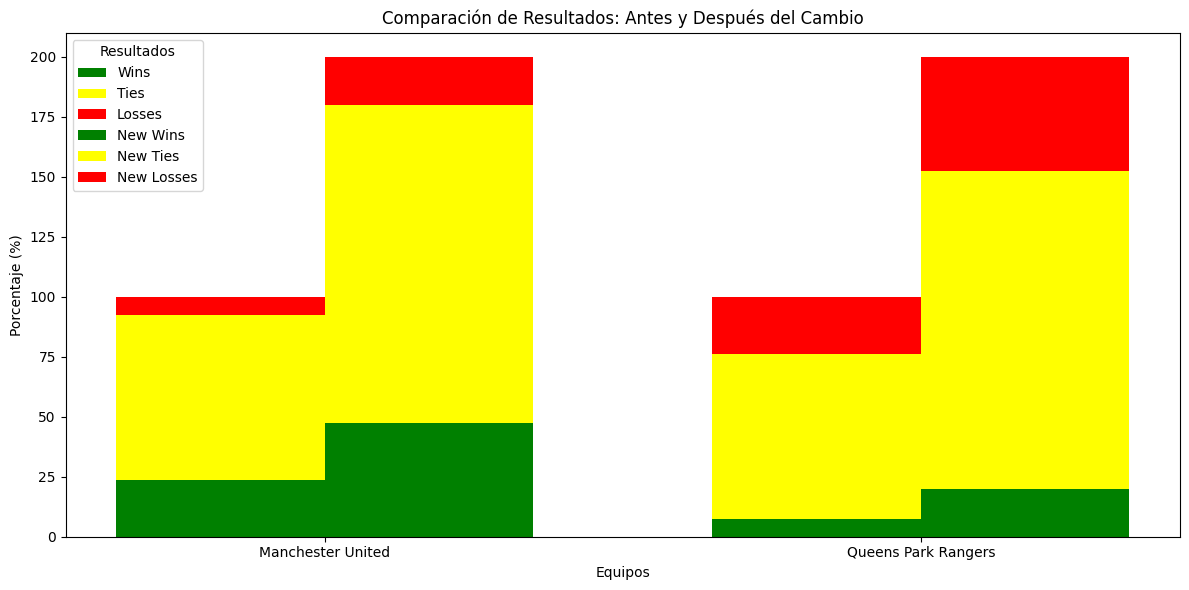

In [40]:
df_plot = df_transposed.transpose()
df_plot.columns = ['Wins', 'Losses', 'Ties', 'New Wins', 'New Losses', 'New Ties']

bar_width = 0.35  # Ancho de las barras
x = np.arange(len(df_plot))  # Posiciones en el eje x

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - bar_width / 2, df_plot['Wins'], width=bar_width, label='Wins', color='green')
ax.bar(x - bar_width / 2, df_plot['Ties'], width=bar_width, label='Ties', color='yellow', bottom=df_plot['Wins'])
ax.bar(x - bar_width / 2, df_plot['Losses'], width=bar_width, label='Losses', color='red', bottom=df_plot['Wins'] + df_plot['Ties'])

ax.bar(x + bar_width / 2, df_plot['New Wins'], width=bar_width, label='New Wins', color='green')
ax.bar(x + bar_width / 2, df_plot['New Ties'], width=bar_width, label='New Ties', color='yellow', bottom=df_plot['New Wins'])
ax.bar(x + bar_width / 2, df_plot['New Losses'], width=bar_width, label='New Losses', color='red', bottom=df_plot['New Wins'] + df_plot['New Ties'])

ax.set_title('Comparación de Resultados: Antes y Después del Cambio')
ax.set_ylabel('Porcentaje (%)')
ax.set_xlabel('Equipos')
ax.set_xticks(x)
ax.set_xticklabels([f'{teams[0]}', f'{teams[1]}'])
ax.legend(title='Resultados')

plt.tight_layout()
plt.show()

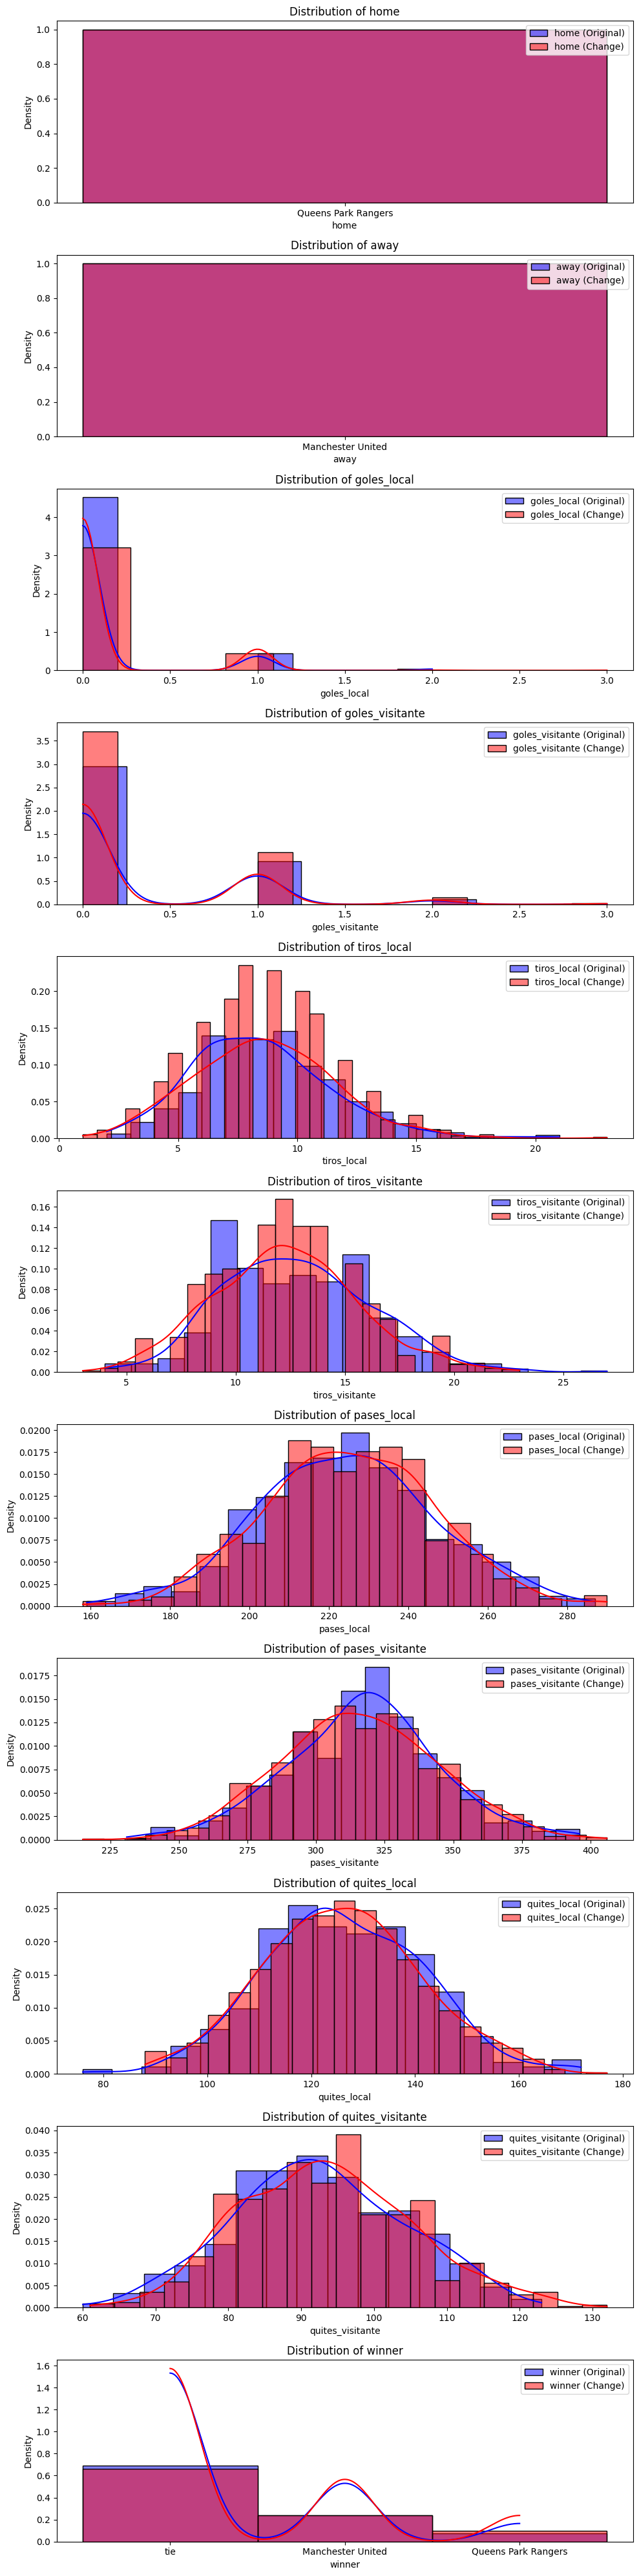

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = df_results.columns
plt.figure(figsize=(10,40))
for i, column in enumerate(columns):
    plt.subplot(len(columns), 1, i + 1)  
    sns.histplot(df_results[column], kde=True, color='blue', label=f'{column} (Original)', stat='density')
    sns.histplot(df_results_change[column], kde=True, color='red', label=f'{column} (Change)', stat='density')
    plt.legend()
    plt.title(f'Distribution of {column}')
    
plt.tight_layout()  
plt.show()


## Graficos

In [ ]:
# def simulate_and_compare(teams_list, players_dict, num_matches=100):
#     home_players = choose_teams(teams_list, players_dict)
#     away_players = choose_teams(teams_list, players_dict)
    
#     df_results = simulate_matches(num_matches, home_players, away_players)

#     home_players_change = choose_teams(teams_list, players_dict)
#     away_players_change = choose_teams(teams_list, players_dict)
    
#     df_results_change = simulate_matches(num_matches, home_players_change, away_players_change)

#     home_players_names = [player[0] for team, players in home_players.items() for player in players]
#     away_players_names = [player[0] for team, players in away_players.items() for player in players]
#     home_players_change_names = [player[0] for team, players in home_players_change.items() for player in players]
#     away_players_change_names = [player[0] for team, players in away_players_change.items() for player in players]

#     summary_data = {
#         'home_players': home_players_names,
#         'away_players': away_players_names,
#         'home_players_change': home_players_change_names,
#         'away_players_change': away_players_change_names,
#     }
    
#     summary_data['home_player_diff'] = list(set(home_players_names) - set(home_players_change_names))
#     summary_data['away_player_diff'] = list(set(away_players_names) - set(away_players_change_names))

#     home_goals = df_results['goles_local'].mean()
#     away_goals = df_results['goles_visitante'].mean()
    
#     home_goals_change = df_results_change['goles_local'].mean()
#     away_goals_change = df_results_change['goles_visitante'].mean()

#     summary_data.update({
#         'home_goals': home_goals,
#         'away_goals': away_goals,
#         'home_goals_change': home_goals_change,
#         'away_goals_change': away_goals_change,
#         'home_goals_%_change': ((home_goals_change - home_goals) / home_goals) * 100 if home_goals != 0 else None,
#         'away_goals_%_change': ((away_goals_change - away_goals) / away_goals) * 100 if away_goals != 0 else None,
#     })

#     home_shots = df_results['tiros_local'].mean()
#     away_shots = df_results['tiros_visitante'].mean()
    
#     home_shots_change = df_results_change['tiros_local'].mean()
#     away_shots_change = df_results_change['tiros_visitante'].mean()

#     summary_data.update({
#         'home_shots': home_shots,
#         'away_shots': away_shots,
#         'home_shots_change': home_shots_change,
#         'away_shots_change': away_shots_change,
#         'home_shots_%_change': ((home_shots_change - home_shots) / home_shots) * 100 if home_shots != 0 else None,
#         'away_shots_%_change': ((away_shots_change - away_shots) / away_shots) * 100 if away_shots != 0 else None,
#     })

#     home_interceptions = df_results['quites_local'].mean()
#     away_interceptions = df_results['quites_visitante'].mean()
    
#     home_interceptions_change = df_results_change['quites_local'].mean()
#     away_interceptions_change = df_results_change['quites_visitante'].mean()

#     summary_data.update({
#         'home_interceptions': home_interceptions,
#         'away_interceptions': away_interceptions,
#         'home_interceptions_change': home_interceptions_change,
#         'away_interceptions_change': away_interceptions_change,
#         'home_interceptions_%_change': ((home_interceptions_change - home_interceptions) / home_interceptions) * 100 if home_interceptions != 0 else None,
#         'away_interceptions_%_change': ((away_interceptions_change - away_interceptions) / away_interceptions) * 100 if away_interceptions != 0 else None,
#     })

#     # Calculate rival passes
#     home_passes = df_results['pases_visitante'].mean()
#     away_passes = df_results['pases_local'].mean()
    
#     home_passes_change = df_results_change['pases_visitante'].mean()
#     away_passes_change = df_results_change['pases_local'].mean()

#     summary_data.update({
#         'home_passes': home_passes,
#         'away_passes': away_passes,
#         'home_passes_%_change': ((home_passes_change - home_passes) / home_passes) * 100 if home_passes != 0 else None,
#         'away_passes_%_change': ((away_passes_change - away_passes) / away_passes) * 100 if away_passes != 0 else None,
#     })

#     home_goals_per_shot = df_results['goles_local'].sum() / df_results['tiros_local'].sum() if home_shots > 0 else None
#     away_goals_per_shot = df_results['goles_visitante'].sum() / df_results['tiros_visitante'].sum() if home_shots > 0 else None
    
#     home_goals_per_shot_change = home_goals_change / home_shots_change if home_shots_change > 0 else None
#     away_goals_per_shot_change = away_goals_change / away_shots_change if away_shots_change > 0 else None

#     summary_data.update({
#         'home_goals_per_shot': home_goals_per_shot,
#         'away_goals_per_shot': away_goals_per_shot,
#         'home_goals_per_shot_change': home_goals_per_shot_change,
#         'away_goals_per_shot_change': away_goals_per_shot_change,
#     })

#     summary_df = pd.DataFrame([summary_data])
#     return summary_df, df_results, df_results_change


# summary_results_df = simulate_and_compare(teams_list, players_dict)


In [ ]:
# summary_results_df[0].columns

In [ ]:
# path = '/Users/luisalawson/Downloads/summary_results_df.xlsx'

In [ ]:
# summary_results_df[0].to_excel(path, index = False)

In [ ]:
# player_change = (summary_results_df[0]['away_player_diff'])[0]

In [ ]:
# columnas = ['away_goals', 'away_goals_change']
# porcentaje_cambio = 'away_goals_%_change'

# fig, ax = plt.subplots(figsize=(10, 6))

# bars = ax.bar(columnas, summary_results_df[columnas].iloc[0], color=['cornflowerblue', 'palevioletred'])

# center_position = (bars[0].get_x() + bars[1].get_x() + bars[1].get_width()) / 2

# ax.annotate(f'{summary_results_df[porcentaje_cambio].iloc[0]:.2f}%',
#             xy=(center_position, max([bar.get_height() for bar in bars])),
#             xytext=(0, 5),  
#             textcoords='offset points',
#             ha='center', va='bottom', color='red')

# ax.set_ylabel('Goles Promedio', fontsize=12)
# ax.set_ylim(0.0,2.5) #esto it cambiandolo para que se lea bien el numero con los limites del grafico

# nuevas_etiquetas = [f'Con {player_change}', f'Sin {player_change} (reemplazo: ..)']
# ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)

# ax.set_title(f'Modificación de Goles MC - {player_change}', fontsize=14)
# plt.show()

In [ ]:
# columnas = ['away_shots', 'away_shots_change'] #cambiar segun analisis
# porcentaje_cambio = 'away_shots_%_change' #cambiar segun analisis

# fig, ax = plt.subplots(figsize=(10, 6))

# bars = ax.bar(columnas, summary_results_df[columnas].iloc[0], color=['cornflowerblue', 'palevioletred'])

# center_position = (bars[0].get_x() + bars[1].get_x() + bars[1].get_width()) / 2

# ax.annotate(f'{summary_results_df[porcentaje_cambio].iloc[0]:.2f}%',
#             xy=(center_position, max([bar.get_height() for bar in bars])),
#             xytext=(0, 5),  
#             textcoords='offset points',
#             ha='center', va='bottom', color='red')

# ax.set_ylabel('Tiros Promedio', fontsize=12) #cambiar segun analisis
# ax.set_ylim(0,10.2) #esto it cambiandolo para que se lea bien el numero con los limites del grafico

# nuevas_etiquetas = [f'Con {player_change}', f'Sin {player_change} (reemplazo: ..)']
# ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)

# ax.set_title(f'Modificación de Tiros LIV - {player_change}', fontsize=14)  #cambiar segun analisis
# plt.show()